# DACON - 주차수요 예측 AI 경진대회
### 주제: 유형 별 임대주택 설계 시 단지 내 적정 주차 수요 예측
평가 방식: MAE (Mean Absolute Error)

target: 등록차량수

## 라이브러리 불러오기

In [ ]:
!pip install pycaret
!pip install shap

In [ ]:
# 한글 폰트 깨짐 현상 해결 위함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pycaret.regression import *
import os
plt.rc('font', family='NanumBarunGothic') # 한글 폰트 설정
from google.colab import drive 
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


## 파일 불러오기

In [ ]:
path = os.path.join("/content", "gdrive", "MyDrive", "data")

In [ ]:
train = pd.read_csv(path + "/train.csv")
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [ ]:
test = pd.read_csv(path + "/test.csv")
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


In [ ]:
ag = pd.read_csv(path + "/age_gender_info.csv")
ag.set_index('지역', inplace=True)
ag.head()

,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
지역,,,,,,,,,,,,,,,,,,,,,,
경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,0.067600,0.086873,0.072570,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,0.067925,0.085751,0.068819,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,0.078355,0.077345,0.064859,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,0.066645,0.081408,0.074382,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


In [ ]:
car = pd.read_excel(path+'/2020년_12월_자동차_등록자료_통계.xlsx', skiprows=[0,1,2])
car.drop('Unnamed: 1', axis=1, inplace=True)
car.drop(0, axis=0, inplace=True)
car.rename(columns={'자가용': '승용_자가용', '자가용.1' : '승합_자가용', '용도별' : '지역'}, inplace=True)
car.dropna(subset=['지역'], inplace=True)
car.set_index('지역', inplace=True)
car.head()

,관용,승용_자가용,영업용,계,관용.1,승합_자가용,영업용.1,계.1,관용.2,자가용.2,영업용.2,계.2,관용.3,자가용.3,영업용.3,계.3,관용.4,자가용.4,영업용.4,계.4
지역,,,,,,,,,,,,,,,,,,,,
서울,4607.0,2582001.0,125376.0,2711984.0,3805.0,87315.0,15384.0,106504.0,3937.0,267951.0,58055.0,329943.0,374.0,3625.0,4931.0,8930.0,12723.0,2940892.0,203746.0,3157361.0
부산,1671.0,1103130.0,84544.0,1189345.0,1261.0,34631.0,6164.0,42056.0,1588.0,151295.0,33767.0,186650.0,138.0,1961.0,8890.0,10989.0,4658.0,1291017.0,133365.0,1429040.0
대구,1002.0,1000105.0,25968.0,1027075.0,893.0,25605.0,4003.0,30501.0,1365.0,137478.0,19136.0,157979.0,122.0,1486.0,2033.0,3641.0,3382.0,1164674.0,51140.0,1219196.0
인천,1569.0,1115094.0,309540.0,1426203.0,1048.0,36779.0,11512.0,49339.0,1311.0,160596.0,31354.0,193261.0,120.0,2223.0,5296.0,7639.0,4048.0,1314692.0,357702.0,1676442.0
광주,829.0,561016.0,14521.0,576366.0,597.0,16934.0,2409.0,19940.0,711.0,78289.0,13444.0,92444.0,80.0,1084.0,1826.0,2990.0,2217.0,657323.0,32200.0,691740.0


In [ ]:
pop = pd.read_csv(path + '/202012_202012_주민등록인구및세대현황_연간.csv', encoding='EUC-KR')
pop.head()

,행정구역,2020년_총인구수,2020년_세대수,2020년_세대당 인구,2020년_남자 인구수,2020년_여자 인구수,2020년_남여 비율
0,전국 (1000000000),"51,829,023","23,093,108",2.24,"25,841,029","25,987,994",0.99
1,서울특별시 (1100000000),"9,668,465","4,417,954",2.19,"4,701,723","4,966,742",0.95
2,부산광역시 (2600000000),"3,391,946","1,530,431",2.22,"1,661,000","1,730,946",0.96
3,대구광역시 (2700000000),"2,418,346","1,056,627",2.29,"1,193,109","1,225,237",0.97
4,인천광역시 (2800000000),"2,942,828","1,267,956",2.32,"1,473,943","1,468,885",1.00


## 변수 변경(EDA 전)

In [ ]:
# 길이가 긴 변수명 변경
train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철', '도보 10분거리 내 버스정류장 수': '버스'}, inplace=True)
test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철', '도보 10분거리 내 버스정류장 수': '버스'}, inplace=True)

In [ ]:
# 전용면적 -> 5단위로 변경
train['전용면적'] = round(train['전용면적'] / 5, 0)
test['전용면적'] = round(test['전용면적'] / 5, 0)

In [ ]:
# 임대보증금, 임대료 float으로 형변환
train.loc[train['임대보증금'] == '-', '임대보증금'] = np.nan
test.loc[test['임대보증금'] == '-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train['임대료'] == '-', '임대료'] = np.nan
test.loc[test['임대료'] == '-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [ ]:
# age_gender_info 와 train data left outer join
train_merge = pd.merge(left=train, right=ag, how='left', on='지역')
train_merge.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),40대(남자),50대(여자),50대(남자),60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,C2483,900,아파트,경상북도,국민임대,8.0,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,C2483,900,아파트,경상북도,국민임대,8.0,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
2,C2483,900,아파트,경상북도,국민임대,10.0,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
3,C2483,900,아파트,경상북도,국민임대,10.0,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
4,C2483,900,아파트,경상북도,국민임대,10.0,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,0.030158,0.033195,0.056346,0.06136,0.060096,0.067859,0.053433,0.049572,0.08366,0.072613,0.087149,0.072146,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014


## 오류 데이터 처리

DACON 측에서 공지한 오류 데이터 처리<br/>
https://dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent

1번 오류는 총 세대수와 전용 면적 별 세대수 합계의 차이가 큰 경우 큰 수로 대체함. <br/>
발생 원인이 '분양' 아파트 / 상가의 혼합인데, 임대/분양 유형에 관계 없이 전체 세대수에 대해서 주차면수가 추정되어야 한다고 생각. <br/>
2, 3번 오류는 주최 측에서 문제가 된 단지 코드에 대한 데이터를 삭제하는 것을 권장하였으므로 삭제함.

In [ ]:
# 전용면적 별 세대수 합
train_sum = train[['전용면적별세대수', '단지코드']].groupby(by='단지코드').sum()
test_sum = test[['전용면적별세대수', '단지코드']].groupby(by='단지코드').sum()

In [ ]:
# 총세대수를 단지코드 별로 묶기 위함
train_av = train[['총세대수', '단지코드']].groupby(by='단지코드').mean()
test_av = test[['총세대수', '단지코드']].groupby(by='단지코드').mean()

In [ ]:
# 1번에서 전용면적별 세대수 합이 총세대수보다 큰 경우가 있는지 확인 
comp_tr = [i for i in train_sum.index if train_sum['전용면적별세대수'][i] > train_av['총세대수'][i]]
comp_te = [i for i in test_sum.index if test_sum['전용면적별세대수'][i] > test_av['총세대수'][i]]
len(comp_tr), len(comp_te)

(0, 0)

총세대수가 전용면적별 세대수의 합보다 크므로, 총세대수는 그대로 유지하고 모델 구축 시 전용면적별 세대수는 사용하지 않을 예정

In [ ]:
# 2, 3번에서 문제가 된 단지코드 삭제
train.drop(train.loc[train['단지코드'].isin(['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'].isin(['C2675', 'C2335', 'C1327'])].index, axis=0, inplace=True)

In [ ]:
train.shape, test.shape

((2869, 15), (1008, 14))

## 외부데이터 추가

In [ ]:
cars = car[['승용_자가용', '승합_자가용']].copy()
cars['자가용 합계'] = cars['승용_자가용'] + cars['승합_자가용']
cars.rename(index={'서울': '서울특별시', '부산':'부산광역시', '대구':'대구광역시', '인천':'인천광역시', '광주':'광주광역시', '대전':'대전광역시',   
                   '울산':'울산광역시', '세종':'세종특별자치시', '경기':'경기도', '강원':'강원도', '충북':'충청북도', '충남':'충청남도', 
                   '전북':'전라북도', '전남':'전라남도', '경북':'경상북도', '경남':'경상남도', '제주':'제주특별자치도'}, inplace=True)
cars.drop(['합계', '월간증감', '년간증감'], axis=0, inplace=True)
cars.drop(['승용_자가용', '승합_자가용'], axis=1, inplace=True)
cars.head()

,자가용 합계
지역,
서울특별시,2669316.0
부산광역시,1137761.0
대구광역시,1025710.0
인천광역시,1151873.0
광주광역시,577950.0


In [ ]:
pops = pop[['행정구역', '2020년_세대수']].copy()
pops.rename( columns={'행정구역':'지역','2020년_세대수':'세대수'}, inplace=True)
pops.set_index('지역', inplace=True)
pops.index = pops.index.str.replace(r'[^가-힣]', '')
pops.drop('전국', axis=0, inplace=True)
pops.head()

,세대수
지역,
서울특별시,"4,417,954"
부산광역시,"1,530,431"
대구광역시,"1,056,627"
인천광역시,"1,267,956"
광주광역시,"633,582"


## EDA

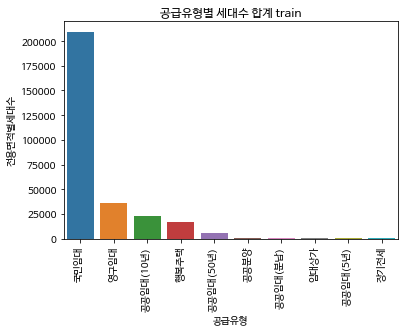

In [ ]:
sns.barplot(data=train.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
            x=train.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
plt.xticks(rotation=90)
plt.title('공급유형별 세대수 합계 train')
plt.show()

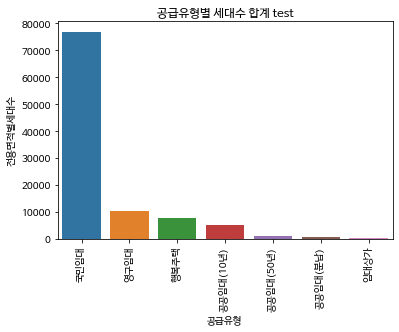

In [ ]:
sns.barplot(data=test.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False),
            x=test.groupby(['공급유형']).sum().sort_values(by=['전용면적별세대수'], ascending=False).index, y='전용면적별세대수')
plt.xticks(rotation=90)
plt.title('공급유형별 세대수 합계 test')
plt.show()

국민임대가 매우 높은 비율을 차지하고 있음

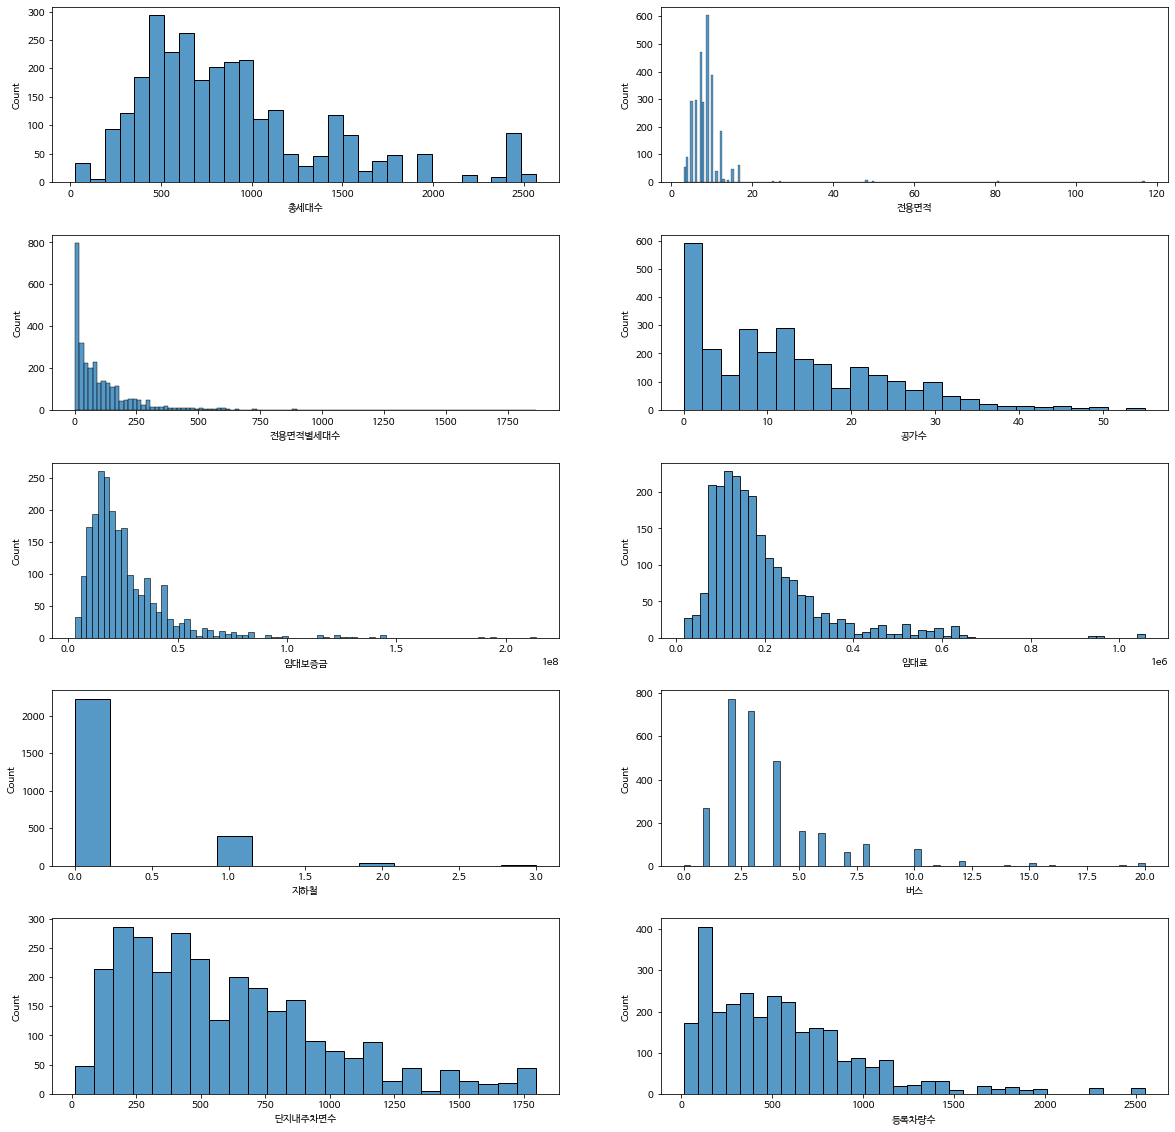

In [ ]:
numeric_cols = []
for col in train.columns:
    if train[col].dtypes != 'object':
        numeric_cols.append(col)

fig = plt.figure(figsize=(20, 20))
for i, n in enumerate(numeric_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace=0.3)
    sns.histplot(train[n])

전체적으로 skew된 형태를 띄고 있음

In [ ]:
# 전체 평균
ag.loc['전체평균'] = ag.mean()
# 광역시 평균
ag.loc['광역시평균'] = ag.loc[(ag.index.str.contains('시')) & (~ag.index.str.contains('세종'))].mean() # 세종시는 광역시가 아니므로 제외
# 수도권 평균
ag.loc['수도권평균'] = ag.loc[['서울특별시', '경기도']].mean()
# 도 평균
ag.loc['도평균'] = ag.loc[ag.index.str.contains('도')].mean()

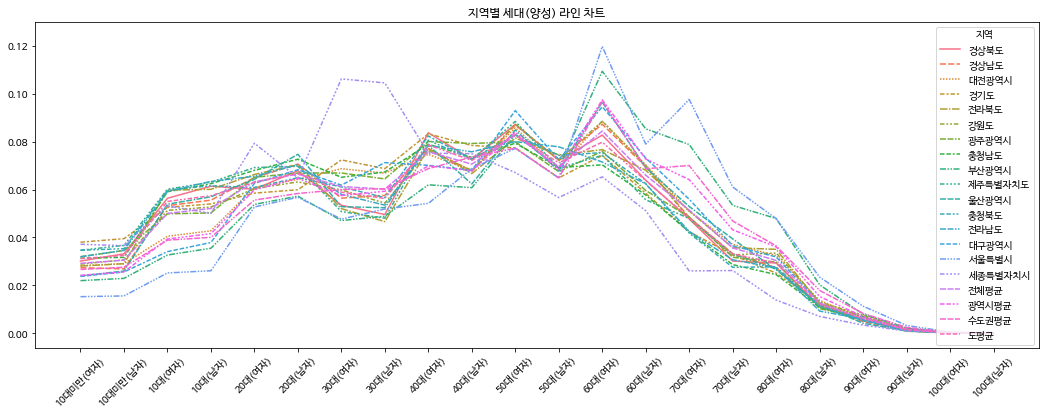

In [ ]:
fig = plt.figure(figsize = (18, 6))
sns.lineplot(data=ag.T, )
plt.title('지역별 세대(양성) 라인 차트')
plt.xticks(rotation=45)
plt.ylim(top=0.13)
plt.show()

- 같은 나이대에서 성별에 따른 편차 존재. 대체로 여성이 더 높은 비율을 보임
- 서울, 부산: 60대 여성에서 피크, 서울: 70대 여성에서도 피크
- 세종: 30대에서 높은 비율

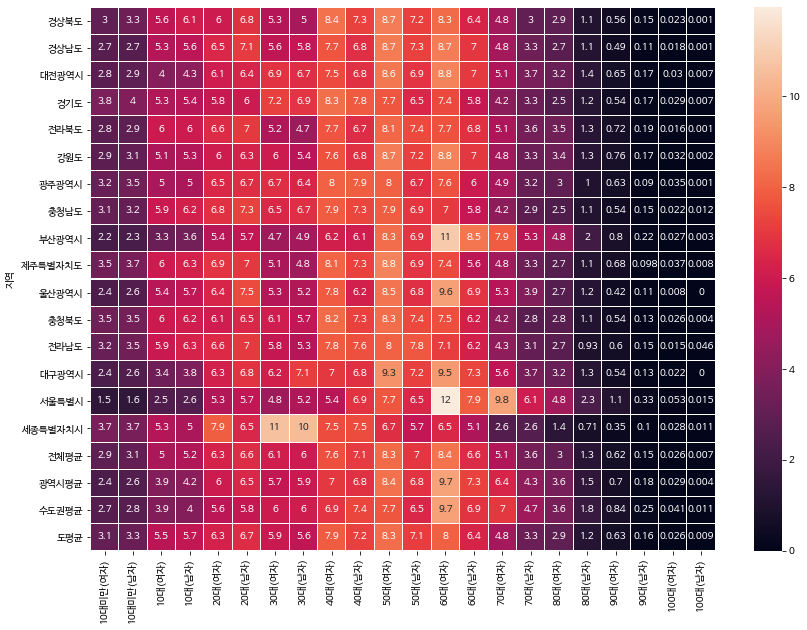

In [ ]:
# 데이터를 퍼센트로 바꾸어 heatmap으로 나타냄
plt.figure(figsize=(14, 10))
sns.heatmap((ag*100).round(3),
           annot=True, linewidths=0.01,)

plt.show()

- 인구가 많은 특별시, 광역시, 수도권에서 60, 70대의 비중이 높다
- 세종시는 20, 30대 청년층의 비중이 높다

## 결측치 처리

In [ ]:
train.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금       581
임대료         584
지하철         207
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

In [ ]:
test.isna().sum()

단지코드          0
총세대수          0
임대건물구분        0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          2
임대보증금       186
임대료         186
지하철          38
버스            0
단지내주차면수       0
dtype: int64

In [ ]:
test.loc[(pd.isna(test['자격유형']) == True)]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,9.0,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,5.0,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0


In [ ]:
test.loc[test['단지코드'] == 'C2411']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,8.0,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,8.0,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,8.0,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,9.0,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,10.0,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


In [ ]:
# 같은 단지코드에서 임대건물 구분, 공급유형이 같은 경우 같은 자격유형으로 매핑
test.loc[(test['단지코드']=='C2411') & test['자격유형'].isnull(), '자격유형'] = 'A'
test.loc[(test['단지코드']=='C2253') & test['자격유형'].isnull(), '자격유형'] = 'C'

In [ ]:
# 지하철, 버스의 결측치는 0으로 대체
train.loc[train['지하철'].isnull(), '지하철'] = 0
train.loc[train['버스'].isnull(), '버스'] = 0
test.loc[test['지하철'].isnull(), '지하철'] = 0

In [ ]:
train[train['임대보증금'].isnull()].공급유형.value_counts()

임대상가    562
국민임대      8
공공분양      7
행복주택      4
Name: 공급유형, dtype: int64

In [ ]:
# 임대상가는 임대보증금, 임대료에 대한 정보가 아예 없으므로 0으로 대체
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '임대상가'), '임대보증금'] = 0
train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '임대상가'), '임대료'] = 0

In [ ]:
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '국민임대')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2547,C1326,1934,아파트,부산광역시,국민임대,5.0,472,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2548,C1326,1934,아파트,부산광역시,국민임대,5.0,104,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2549,C1326,1934,아파트,부산광역시,국민임대,5.0,590,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2550,C1326,1934,아파트,부산광역시,국민임대,8.0,464,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2551,C1326,1934,아파트,부산광역시,국민임대,9.0,304,43.0,H,NaN,NaN,0.0,4.0,1670.0,1153.0
2906,C2186,924,아파트,대구광역시,국민임대,6.0,238,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2907,C2186,924,아파트,대구광역시,국민임대,6.0,38,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2908,C2186,924,아파트,대구광역시,국민임대,7.0,220,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0


In [ ]:
# 같은 단지/지역의 데이터 중 임대보증금, 임대료 정보가 있는 데이터의 (평균) 단위면적당가 * 전용면적으로 결측치 처리
train_ = train.loc[(train['지역'] == '부산광역시') & (train['공급유형'] == '국민임대')]
train_['단위당임대보증금'] = train_['임대보증금'] / train_['전용면적']
train_['단위당임대료'] = train_['임대료'] / train_['전용면적']
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '국민임대') & (train['지역'] =='부산광역시'), 
          '임대보증금'] = train_['단위당임대보증금'].mean() * train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '국민임대') & (train['지역'] =='부산광역시'), 
          '전용면적']
train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '국민임대') & (train['지역'] =='부산광역시'), 
          '임대료'] = train_['단위당임대료'].mean() * train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '국민임대') & (train['지역'] =='부산광역시'), 
          '전용면적']

In [ ]:
train.loc[(train['단지코드'] == 'C2186') & (train['공급유형'] == '국민임대')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2906,C2186,924,아파트,대구광역시,국민임대,6.0,238,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2907,C2186,924,아파트,대구광역시,국민임대,6.0,38,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2908,C2186,924,아파트,대구광역시,국민임대,7.0,220,0.0,H,NaN,NaN,0.0,8.0,664.0,744.0
2909,C2186,924,아파트,대구광역시,국민임대,9.0,188,0.0,H,25981000.0,248630.0,0.0,8.0,664.0,744.0


In [ ]:
# 같은 단지/지역의 데이터 중 임대보증금, 임대료 정보가 있는 데이터의 단위면적당가 * 전용면적 으로 결측치 처리
deposit = train.loc[(~train['임대보증금'].isnull()) & (train['단지코드'] == 'C2186'), '임대보증금'].values[0]
size = train.loc[(~train['임대보증금'].isnull()) & (train['단지코드'] == 'C2186'), '전용면적'].values[0]
train.loc[(train['임대보증금'].isnull()) & (train['단지코드'] == 'C2186'), '임대보증금'] = (deposit / size) * train.loc[(train['임대보증금'].isnull()) & (train['단지코드'] == 'C2186'), '전용면적']
rent = train.loc[(~train['임대료'].isnull()) & (train['단지코드'] == 'C2186'), '임대료'].values[0]
train.loc[(train['임대료'].isnull()) & (train['단지코드'] == 'C2186'), '임대료'] = (rent / size) * train.loc[(train['임대료'].isnull()) & (train['단지코드'] == 'C2186'), '전용면적']

In [ ]:
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '공공분양')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2331,C1350,1401,아파트,대전광역시,공공분양,15.0,317,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2332,C1350,1401,아파트,대전광역시,공공분양,15.0,137,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2333,C1350,1401,아파트,대전광역시,공공분양,15.0,22,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2334,C1350,1401,아파트,대전광역시,공공분양,17.0,164,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2335,C1350,1401,아파트,대전광역시,공공분양,17.0,19,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2336,C1350,1401,아파트,대전광역시,공공분양,17.0,26,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0
2337,C1350,1401,아파트,대전광역시,공공분양,17.0,26,2.0,D,NaN,NaN,0.0,6.0,1636.0,2315.0


In [ ]:
# 공공분양은 임대보증금, 임대료가 없으므로 0으로 대체
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '공공분양'), '임대보증금'] = 0
train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '공공분양'), '임대료'] = 0

In [ ]:
train.loc[(train['임대보증금'].isnull()) & (train['공급유형'] == '행복주택')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2680,C1786,480,아파트,강원도,행복주택,3.0,156,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2681,C1786,480,아파트,강원도,행복주택,5.0,136,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2682,C1786,480,아파트,강원도,행복주택,5.0,72,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2683,C1786,480,아파트,강원도,행복주택,5.0,24,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0


In [ ]:
train.loc[(train['공급유형'] == '행복주택') & (train['지역'] =='강원도')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
2680,C1786,480,아파트,강원도,행복주택,3.0,156,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2681,C1786,480,아파트,강원도,행복주택,5.0,136,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2682,C1786,480,아파트,강원도,행복주택,5.0,72,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2683,C1786,480,아파트,강원도,행복주택,5.0,24,25.0,K,NaN,NaN,0.0,3.0,338.0,345.0
2684,C1786,480,아파트,강원도,행복주택,7.0,92,25.0,J,30560000.0,145160.0,0.0,3.0,338.0,345.0


In [ ]:
# 같은 단지/지역의 데이터 중 임대보증금, 임대료 정보가 있는 데이터의 단위면적당가 * 전용면적으로 결측치 처리
deposit = train.loc[(~train['임대보증금'].isnull()) & (train['단지코드'] == 'C1786'), '임대보증금'].values[0]
size = train.loc[(~train['임대보증금'].isnull()) & (train['단지코드'] == 'C1786'), '전용면적'].values[0]
train.loc[(train['임대보증금'].isnull()) & (train['단지코드'] == 'C1786'), '임대보증금'] = (deposit / size) * train.loc[(train['임대보증금'].isnull()) & (train['단지코드'] == 'C1786'), '전용면적']

In [ ]:
rent = train.loc[(~train['임대료'].isnull()) & (train['단지코드'] == 'C1786'), '임대료'].values[0]
train.loc[(train['임대료'].isnull()) & (train['단지코드'] == 'C1786'), '임대료'] = (deposit / size) * train.loc[(train['임대료'].isnull()) & (train['단지코드'] == 'C1786'), '전용면적']

In [ ]:
train.loc[(train['임대료'].isnull()) & (train['공급유형'] == '장기전세'), '임대료'] = 0

In [ ]:
test[test['임대보증금'].isnull()].공급유형.value_counts()

임대상가    177
영구임대      5
행복주택      4
Name: 공급유형, dtype: int64

In [ ]:
# 임대상가는 임대보증금, 임대료에 대한 정보가 아예 없으므로 0으로 대체
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '임대상가'), '임대보증금'] = 0
test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '임대상가'), '임대료'] = 0

In [ ]:
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '영구임대')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
76,C1006,1505,아파트,대전광역시,영구임대,5.0,10,27.0,D,NaN,NaN,2.0,5.0,428.0
77,C1006,1505,아파트,대전광역시,영구임대,5.0,10,27.0,D,NaN,NaN,2.0,5.0,428.0
79,C1006,1505,아파트,대전광역시,영구임대,11.0,6,27.0,D,NaN,NaN,2.0,5.0,428.0
1005,C2152,120,아파트,강원도,영구임대,5.0,66,9.0,C,NaN,NaN,0.0,1.0,40.0
1006,C2152,120,아파트,강원도,영구임대,7.0,54,9.0,C,NaN,NaN,0.0,1.0,40.0


In [ ]:
# train 데이터에서 아파트 - 자격유형 D는 공공분양 -> 임대보증금, 임대료 0이었으므로 정보가 없으므로 0으로 처리
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '영구임대') & (test['단지코드'] == 'C1006'), '임대보증금'] = 0
test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '영구임대') & (test['단지코드'] == 'C1006'), '임대료'] = 0

In [ ]:
test.loc[(test['공급유형'] == '영구임대') & (test['지역'] == '강원도') & (test['자격유형'] == 'C')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,5.0,745,0.0,C,2249000.0,44770.0,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,6.0,239,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,6.0,149,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
308,C1729,627,아파트,강원도,영구임대,7.0,180,0.0,C,5009000.0,93000.0,0.0,5.0,131.0
309,C1729,627,아파트,강원도,영구임대,7.0,64,0.0,C,5009000.0,93000.0,0.0,5.0,131.0
310,C1729,627,아파트,강원도,영구임대,7.0,27,0.0,C,5009000.0,93000.0,0.0,5.0,131.0
311,C1729,627,아파트,강원도,영구임대,7.0,44,0.0,C,5009000.0,93000.0,0.0,5.0,131.0
312,C1729,627,아파트,강원도,영구임대,8.0,180,0.0,C,6496000.0,120600.0,0.0,5.0,131.0
313,C1729,627,아파트,강원도,영구임대,8.0,56,0.0,C,6496000.0,120600.0,0.0,5.0,131.0
314,C1729,627,아파트,강원도,영구임대,8.0,23,0.0,C,6496000.0,120600.0,0.0,5.0,131.0


In [ ]:
test_ = test.loc[(test['공급유형'] == '영구임대') & (test['지역'] == '강원도') & (test['자격유형'] == 'C')]
test_['단위당임대보증금'] = test_['임대보증금'] / test_['전용면적']
test_['단위당임대료'] = test_['임대료'] / test_['전용면적']
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '영구임대') & (test['지역'] =='강원도'), 
          '임대보증금'] = test_['단위당임대보증금'].mean() * test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '영구임대') & (test['지역'] =='강원도'), 
          '전용면적']
test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '영구임대') & (test['지역'] =='강원도'), 
          '임대료'] = test_['단위당임대료'].mean() * test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '영구임대') & (test['지역'] =='강원도'), 
          '전용면적']

In [ ]:
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '행복주택')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
1014,C1267,675,아파트,경상남도,행복주택,3.0,50,38.0,L,NaN,NaN,0.0,1.0,467.0
1015,C1267,675,아파트,경상남도,행복주택,5.0,66,38.0,L,NaN,NaN,0.0,1.0,467.0
1016,C1267,675,아파트,경상남도,행복주택,5.0,8,38.0,L,NaN,NaN,0.0,1.0,467.0
1017,C1267,675,아파트,경상남도,행복주택,7.0,126,38.0,L,NaN,NaN,0.0,1.0,467.0


In [ ]:
test.loc[(test['공급유형'] == '행복주택') & (test['지역'] =='경상남도')]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
854,C1003,480,아파트,경상남도,행복주택,3.0,128,29.0,J,12000000.0,61000.0,0.0,3.0,339.0
855,C1003,480,아파트,경상남도,행복주택,5.0,172,29.0,J,19600000.0,100000.0,0.0,3.0,339.0
856,C1003,480,아파트,경상남도,행복주택,5.0,48,29.0,J,19600000.0,100000.0,0.0,3.0,339.0
857,C1003,480,아파트,경상남도,행복주택,5.0,30,29.0,J,18800000.0,96000.0,0.0,3.0,339.0
858,C1003,480,아파트,경상남도,행복주택,7.0,56,29.0,J,25600000.0,131000.0,0.0,3.0,339.0
859,C1003,480,아파트,경상남도,행복주택,7.0,12,29.0,J,25600000.0,131000.0,0.0,3.0,339.0
860,C1003,480,아파트,경상남도,행복주택,9.0,28,29.0,J,30000000.0,154000.0,0.0,3.0,339.0
861,C1003,480,아파트,경상남도,행복주택,9.0,6,29.0,J,30000000.0,154000.0,0.0,3.0,339.0
862,C2268,900,아파트,경상남도,행복주택,3.0,80,45.0,K,33446000.0,17420.0,0.0,2.0,633.0
863,C2268,900,아파트,경상남도,행복주택,3.0,324,45.0,K,33446000.0,17420.0,0.0,2.0,633.0


In [ ]:
test_ = test.loc[(test['공급유형'] == '행복주택') & (test['지역'] == '경상남도')]
test_['단위당임대보증금'] = test_['임대보증금'] / test_['전용면적']
test_['단위당임대료'] = test_['임대료'] / test_['전용면적']
test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '행복주택') & (test['지역'] =='경상남도'), 
          '임대보증금'] = test_['단위당임대보증금'].mean() * test.loc[(test['임대보증금'].isnull()) & (test['공급유형'] == '행복주택') & (test['지역'] =='경상남도'), 
          '전용면적']
test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '행복주택') & (test['지역'] =='경상남도'), 
          '임대료'] = test_['단위당임대료'].mean() * test.loc[(test['임대료'].isnull()) & (test['공급유형'] == '행복주택') & (test['지역'] =='경상남도'), 
          '전용면적']

In [ ]:
train.isna().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
등록차량수       0
dtype: int64

In [ ]:
test.isna().sum()

단지코드        0
총세대수        0
임대건물구분      0
지역          0
공급유형        0
전용면적        0
전용면적별세대수    0
공가수         0
자격유형        0
임대보증금       0
임대료         0
지하철         0
버스          0
단지내주차면수     0
dtype: int64

## 이상치 처리

In [ ]:
pd.concat([train['공급유형'].value_counts(), 
           test['공급유형'].value_counts()], axis=1)

,공급유형,공급유형
국민임대,1727,614.0
임대상가,562,177.0
행복주택,202,120.0
공공임대(10년),175,35.0
영구임대,152,43.0
공공임대(50년),31,13.0
공공분양,7,NaN
공공임대(분납),7,6.0
장기전세,3,NaN
공공임대(5년),3,NaN


test set에는 장기전세, 공공분양, 공공임대(5년)에 대한 정보가 없다. <br/>
장기전세, 공공분양은 train set에서 제외한다.(공공임대(5년)은 다른 공공임대 유형과 묶을 예정이므로 우선 살려둔다.)

In [ ]:
train.drop(train.loc[(train['공급유형']=='장기전세') | (train['공급유형'] == '공공분양')].index, axis=0, inplace=True)

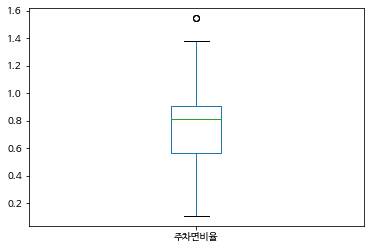

In [ ]:
train['주차면비율'] = train['단지내주차면수'] / train['총세대수']
train['주차면비율'].plot(kind='box')

In [ ]:
# IQR * 1.5
np.percentile(train['주차면비율'], 75) * 1.5

1.363261352844686

In [ ]:
train.drop(train[train['주차면비율'] > np.percentile(train['주차면비율'], 75) * 1.5].index, axis=0, inplace=True)

## 변수 변경(EDA 후)

In [ ]:
# 공공임대 하나로 묶기
train.loc[train['공급유형'].isin(['공공임대(50년)', '공공임대(10년)', '공공임대(분납)', '공공임대(5년)']), '공급유형'] = '공공임대'
test.loc[test['공급유형'].isin(['공공임대(50년)', '공공임대(10년)', '공공임대(분납)', '공공임대(5년)']), '공급유형'] = '공공임대'

In [ ]:
# 하나의 단지코드에 하나의 값만 존재하는 변수들을 따로 모음
unique_cols = ['총세대수', '지역', '공가수', '지하철', '버스', '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [ ]:
train_agg['대중교통'] = train_agg['지하철'] + train_agg['버스']
test_agg['대중교통'] = test_agg['지하철'] + test_agg['버스']

In [ ]:
train_agg.drop(['지하철', '버스'], axis=1, inplace=True)
test_agg.drop(['지하철', '버스'], axis=1, inplace=True)

In [ ]:
# 하나의 단지코드에 복수의 값이 존재하는 변수들 처리
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

In [ ]:
reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter')

,임대건물구분_상가,임대건물구분_아파트
단지코드,,
C1003,0.0,1.0
C1006,1.0,1.0
C1016,0.0,1.0
C1019,0.0,1.0
C1030,0.0,1.0
C1038,0.0,1.0
C1040,0.0,1.0
C1060,0.0,1.0
C1064,0.0,1.0


In [ ]:
reshape_cat_features(data=train, cast_col='공급유형', value_col='counter')

,공급유형_공공임대,공급유형_국민임대,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택
단지코드,,,,,
C1000,0.0,1.0,0.0,0.0,0.0
C1004,0.0,0.0,1.0,1.0,0.0
C1005,0.0,1.0,0.0,0.0,0.0
C1013,0.0,1.0,0.0,0.0,0.0
C1014,0.0,1.0,0.0,0.0,0.0
C1015,0.0,1.0,0.0,0.0,0.0
C1017,0.0,1.0,0.0,0.0,0.0
C1022,0.0,1.0,0.0,0.0,0.0
C1024,1.0,0.0,0.0,0.0,0.0


In [ ]:
train_agg = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='지역', value_col='counter')
                      ], axis=1)

test_agg = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                      reshape_cat_features(data=test, cast_col='지역', value_col='counter')
                     ], axis=1)

In [ ]:
train_agg.shape, test_agg.shape

((410, 29), (147, 27))

In [ ]:
rate = pd.merge(left=pops, right=cars, how='inner', on='지역')
rate['세대수'] = rate['세대수'].str.replace(r'[^0-9]', '')
rate['세대수'] = rate['세대수'].astype('float')
rate['세대당자동차보유율'] = rate['자가용 합계'] / rate['세대수']
rate.head()

,세대수,자가용 합계,세대당자동차보유율
지역,,,
서울특별시,4417954.0,2669316.0,0.604197
부산광역시,1530431.0,1137761.0,0.743425
대구광역시,1056627.0,1025710.0,0.970740
인천광역시,1267956.0,1151873.0,0.908449
광주광역시,633582.0,577950.0,0.912194


In [ ]:
rates = rate[['세대당자동차보유율']].copy()
rates.head()

,세대당자동차보유율
지역,
서울특별시,0.604197
부산광역시,0.743425
대구광역시,0.970740
인천광역시,0.908449
광주광역시,0.912194


In [ ]:
train_merge = pd.merge(left=train_agg, right=ag, how='left', on='지역')
test_merge = pd.merge(left=test_agg, right=ag, how='left', on='지역')

In [ ]:
train_merge = pd.merge(left=train_merge, right=rates, how='left', on='지역')
test_merge = pd.merge(left=test_merge, right=rates, how='left', on='지역')

In [ ]:
train_merge['단지당자동차보유수'] = train_merge['세대당자동차보유율'] * train_merge['총세대수']
test_merge['단지당자동차보유수'] = test_merge['세대당자동차보유율'] * test_merge['총세대수']
train_merge.drop('세대당자동차보유율', axis=1, inplace=True)
test_merge.drop('세대당자동차보유율', axis=1, inplace=True)

In [ ]:
train_merge.set_index(train_agg.index, inplace=True)
test_merge.set_index(test_agg.index, inplace=True)

In [ ]:
train_merge['지역'] = train_merge['지역'].astype('category')
test_merge['지역'] = test_merge['지역'].astype('category')

## 데이터 분리 / 변수선택

In [ ]:
train_merge.drop('임대건물구분_아파트', axis=1, inplace=True)
test_merge.drop('임대건물구분_아파트', axis=1, inplace=True)

In [ ]:
train_merge.drop('지역_서울특별시', axis=1, inplace=True)

In [ ]:
train_merge.drop('지역', axis=1, inplace=True)
test_merge.drop('지역', axis=1, inplace=True)

In [ ]:
train_merge['총세대수'] = train_merge['총세대수'].astype('float')
test_merge['총세대수'] = test_merge['총세대수'].astype('float')

상가가 있을 때 총세대수와 단지내주차면수의 차이가 크기 때문에, 분리해서 모델 학습을 진행

In [ ]:
train_has_store = train_merge.loc[train_merge['공급유형_임대상가'] == 1]
train_apt_only = train_merge.loc[train_merge['공급유형_임대상가'] == 0]

test_has_store = test_merge.loc[test_merge['공급유형_임대상가'] == 1]
test_apt_only = test_merge.loc[test_merge['공급유형_임대상가'] == 0]

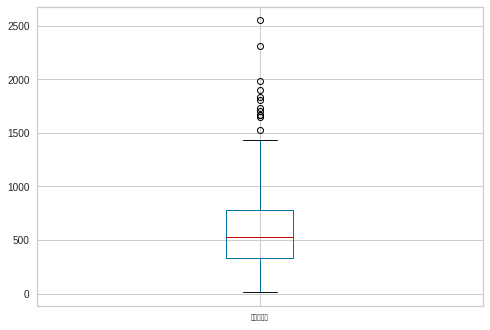

In [ ]:
train_apt_only['등록차량수'].plot(kind='box')

In [ ]:
np.percentile(train_apt_only['등록차량수'], 75) * 1.5

1170.0

In [ ]:
train_apt_only.drop(train_apt_only[train_apt_only['등록차량수'] > np.percentile(train_apt_only['등록차량수'], 75) * 1.5].index, axis=0, inplace=True)

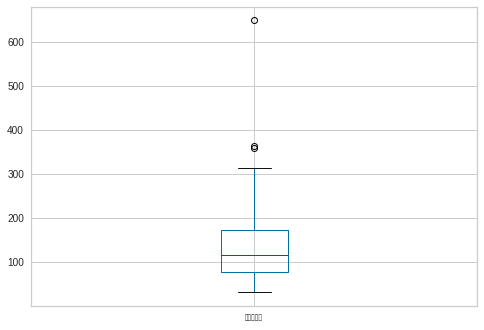

In [ ]:
train_has_store['등록차량수'].plot(kind='box')

In [ ]:
np.percentile(train_has_store['등록차량수'], 75) * 1.5

258.0

In [ ]:
train_has_store.drop(train_has_store[train_has_store['등록차량수'] > np.percentile(train_has_store['등록차량수'], 75) * 1.5].index, axis=0, inplace=True)

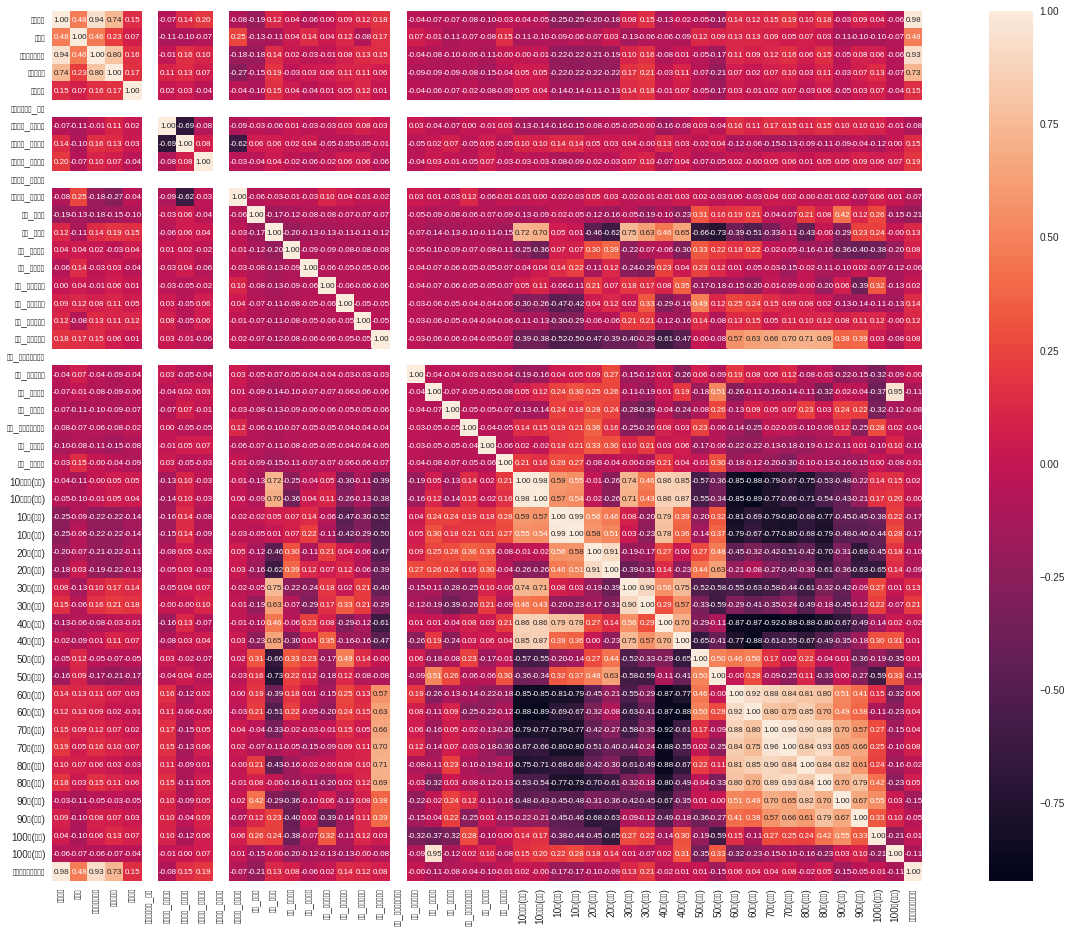

In [ ]:
corr = train_apt_only.corr()
f, ax = plt.subplots(figsize = (24, 16))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', annot_kws={'size':8})

In [ ]:
select_var1 = [i for i in corr['등록차량수'].index if (1>corr['등록차량수'][i] > 0.2 or corr['등록차량수'][i] < -0.2)]
select_var1

['총세대수',
 '공가수',
 '단지내주차면수',
 '공급유형_행복주택',
 '10대(여자)',
 '10대(남자)',
 '20대(여자)',
 '20대(남자)',
 '30대(남자)',
 '50대(남자)',
 '단지당자동차보유수']

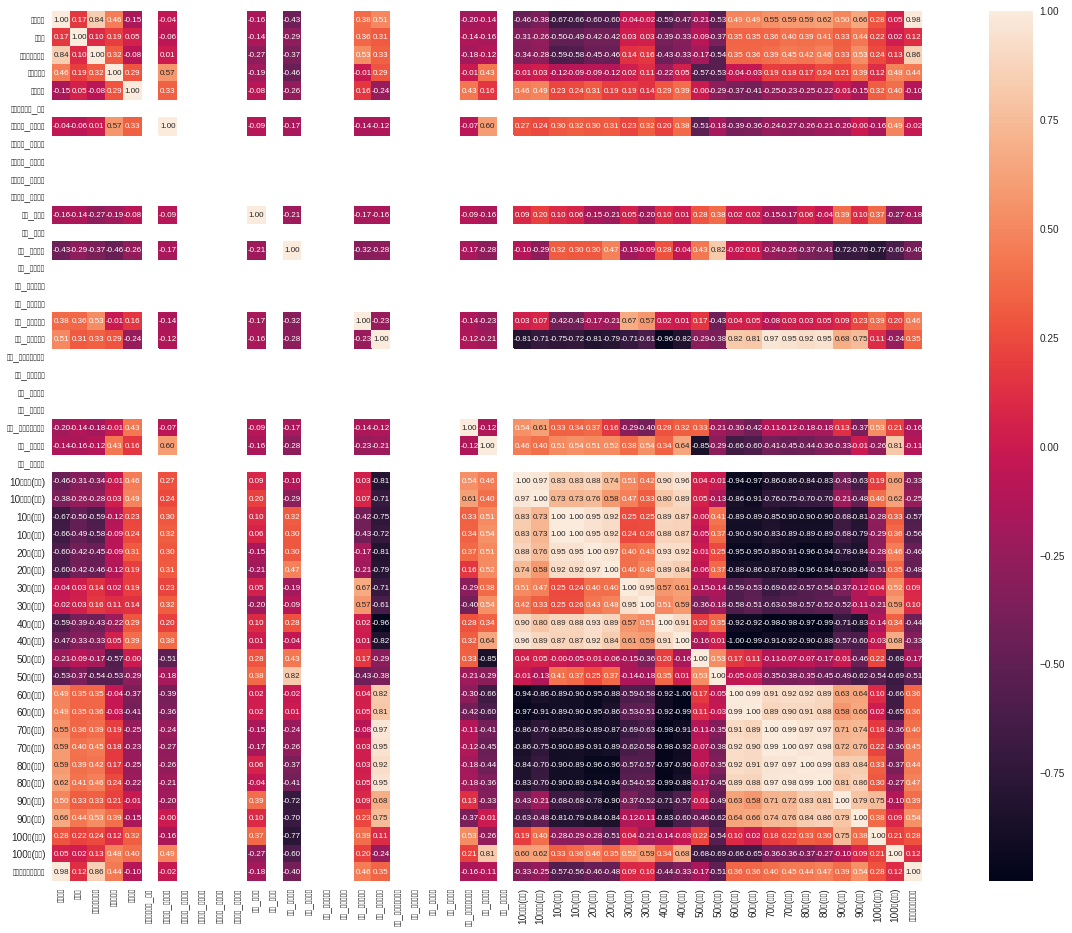

In [ ]:
corr = train_has_store.corr()
f, ax = plt.subplots(figsize = (24, 16))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', annot_kws={'size':8})

In [ ]:
select_var2 = [i for i in corr['등록차량수'].index if (1>corr['등록차량수'][i] > 0.2 or corr['등록차량수'][i] < -0.2)]
select_var2

['총세대수',
 '단지내주차면수',
 '대중교통',
 '공급유형_공공임대',
 '지역_경상남도',
 '지역_부산광역시',
 '지역_충청남도',
 '40대(여자)',
 '50대(여자)',
 '50대(남자)',
 '80대(남자)',
 '90대(여자)',
 '90대(남자)',
 '100대(남자)',
 '단지당자동차보유수']

In [ ]:
test_has_store = test_has_store[select_var2]
test_apt_only = test_apt_only[select_var1]

select_var2.append('등록차량수')
select_var1.append('등록차량수')
train_has_store = train_has_store[select_var2]
train_apt_only = train_apt_only[select_var1]

## 모델 학습

### 상가 있는 경우

In [ ]:
categorical_features = ['공급유형_공공임대', '공급유형_임대상가', '공급유형_영구임대', '공급유형_국민임대', '공급유형_행복주택', '임대건물구분_아파트', '임대건물구분_상가']

In [ ]:
reg1 = setup(train_has_store, target='등록차량수', session_id=123)

,Description,Value
0,session_id,123
1,Target,등록차량수
2,Original Data,"(29, 16)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(20, 15)"


In [ ]:
best_model = compare_models(fold=5,sort='MAE', n_select=4)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,1.709640e+01,5.497182e+02,2.051360e+01,-1.041000e-01,0.2613,2.231000e-01,0.054
lasso,Lasso Regression,1.918740e+01,6.343234e+02,2.278570e+01,-9.856000e-01,0.2656,2.371000e-01,0.020
ridge,Ridge Regression,1.933770e+01,6.304872e+02,2.273220e+01,-9.493000e-01,0.2683,2.395000e-01,0.018
en,Elastic Net,1.975100e+01,6.560287e+02,2.302090e+01,-1.089400e+00,0.2604,2.386000e-01,0.024
et,Extra Trees Regressor,2.318250e+01,8.608168e+02,2.812050e+01,-8.746000e-01,0.2810,2.570000e-01,0.468
ada,AdaBoost Regressor,2.523530e+01,9.602762e+02,2.958600e+01,-1.769300e+00,0.3077,2.774000e-01,0.100
llar,Lasso Least Angle Regression,2.534540e+01,1.054917e+03,2.940590e+01,-2.258600e+00,0.3171,2.857000e-01,0.020
lr,Linear Regression,2.547470e+01,1.164354e+03,3.269750e+01,-1.879600e+00,0.3755,2.953000e-01,0.698
rf,Random Forest Regressor,2.769300e+01,1.271391e+03,3.464810e+01,-2.077300e+00,0.3498,2.962000e-01,0.496
br,Bayesian Ridge,2.796100e+01,1.218415e+03,3.210360e+01,-2.158200e+00,0.3307,3.186000e-01,0.020


In [ ]:
huber = create_model('huber', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,25.9770,793.2773,28.1652,-3.7079,0.2721,0.2217
1,5.2258,29.8832,5.4666,0.9826,0.0644,0.0594
2,24.7813,1050.7404,32.4151,0.5699,0.3698,0.2306
3,22.5630,809.5992,28.4535,0.7331,0.4907,0.5105
4,6.9348,65.0911,8.0679,0.9019,0.1093,0.0932
Mean,17.0964,549.7182,20.5136,-0.1041,0.2613,0.2231
SD,9.0772,420.2319,11.3538,1.8075,0.1590,0.1590


In [ ]:
tuned_huber = tune_model(huber, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,19.7795,675.7668,25.9955,-3.0105,0.2659,0.1660
1,8.1710,73.3946,8.5671,0.9572,0.0999,0.0944
2,24.0104,1007.8263,31.7463,0.5874,0.3662,0.2275
3,14.0503,356.1150,18.8710,0.8826,0.3729,0.3302
4,5.1225,80.5292,8.9738,0.8786,0.1231,0.0765
Mean,14.2268,438.7264,18.8307,0.0591,0.2456,0.1789
SD,7.0163,360.1833,9.1722,1.5400,0.1161,0.0928


In [ ]:
lasso = create_model('lasso', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,36.8167,1527.4735,39.0829,-8.0651,0.3210,0.3201
1,7.0195,63.5717,7.9732,0.9629,0.1028,0.0894
2,19.5953,691.4212,26.2949,0.7169,0.2880,0.1830
3,21.5622,677.4711,26.0283,0.7767,0.4534,0.4643
4,10.9432,211.6797,14.5492,0.6808,0.1630,0.1289
Mean,19.1874,634.3234,22.7857,-0.9856,0.2656,0.2371
SD,10.3211,511.3168,10.7301,3.5411,0.1232,0.1378


In [ ]:
tuned_lasso = tune_model(lasso, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,26.5839,767.6918,27.7073,-3.5560,0.2552,0.2287
1,6.7165,77.1601,8.7841,0.9550,0.1097,0.0885
2,19.8038,664.8514,25.7847,0.7278,0.2606,0.1771
3,17.1165,434.1055,20.8352,0.8569,0.3896,0.3729
4,11.0819,180.8469,13.4479,0.7273,0.1512,0.1304
Mean,16.2605,424.9312,19.3118,-0.0578,0.2333,0.1995
SD,6.8959,266.7030,7.2100,1.7512,0.0976,0.0985


In [ ]:
ridge = create_model('ridge', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,37.0331,1492.4138,38.6318,-7.8571,0.3225,0.3217
1,5.9841,55.0334,7.4185,0.9679,0.1013,0.0790
2,19.8840,705.8038,26.5670,0.7111,0.2916,0.1843
3,21.0142,668.4841,25.8551,0.7796,0.4549,0.4614
4,12.7731,230.7010,15.1888,0.6521,0.1712,0.1513
Mean,19.3377,630.4872,22.7322,-0.9493,0.2683,0.2395
SD,10.3697,498.1987,10.6646,3.4555,0.1230,0.1360


In [ ]:
tuned_ridge = tune_model(ridge, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,28.9088,892.7629,29.8791,-4.2983,0.2735,0.2493
1,6.7052,75.0760,8.6646,0.9562,0.1109,0.0895
2,19.8361,664.0150,25.7685,0.7282,0.2646,0.1794
3,19.1702,530.9188,23.0417,0.8250,0.4105,0.4039
4,10.9677,189.6628,13.7718,0.7140,0.1543,0.1288
Mean,17.1176,470.4871,20.2252,-0.2150,0.2428,0.2102
SD,7.7055,301.5408,7.8378,2.0435,0.1047,0.1106


In [ ]:
en = create_model('en', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,38.4978,1618.9805,40.2366,-8.6082,0.3302,0.3351
1,6.2801,66.2295,8.1382,0.9614,0.1036,0.0831
2,18.8756,631.8754,25.1371,0.7413,0.2676,0.1746
3,24.5430,772.8024,27.7993,0.7452,0.4487,0.4784
4,10.5584,190.2557,13.7933,0.7131,0.1517,0.1220
Mean,19.7510,656.0287,23.0209,-1.0894,0.2604,0.2386
SD,11.3238,548.8721,11.2280,3.7604,0.1239,0.1474


In [ ]:
tuned_en = tune_model(en, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,29.0875,891.7092,29.8615,-4.2920,0.2711,0.2511
1,6.0633,68.8150,8.2955,0.9599,0.1046,0.0818
2,18.6229,591.4612,24.3200,0.7579,0.2458,0.1679
3,18.2144,484.1960,22.0045,0.8404,0.3872,0.3720
4,11.1141,180.2179,13.4245,0.7283,0.1491,0.1297
Mean,16.6204,443.2799,19.5812,-0.2011,0.2316,0.2005
SD,7.7942,294.6680,7.7367,2.0470,0.0989,0.1021


In [ ]:
et = create_model('et', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,32.5825,1300.0745,36.0565,-6.7156,0.3480,0.2833
1,16.7450,428.2243,20.6936,0.7502,0.1836,0.1651
2,16.9325,507.4280,22.5262,0.7923,0.1834,0.1354
3,34.8100,1628.6048,40.3560,0.4631,0.4668,0.5093
4,14.8425,439.7526,20.9703,0.3369,0.2235,0.1919
Mean,23.1825,860.8168,28.1205,-0.8746,0.2810,0.2570
SD,8.6443,504.3333,8.3698,2.9255,0.1108,0.1355


In [ ]:
tuned_et = tune_model(et, optimize='MAE', fold=5, n_iter=50)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:08:40
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min


KeyboardInterrupt: ignored

In [ ]:
blender1 = blend_models(estimator_list=[tuned_huber, tuned_lasso, tuned_en, tuned_ridge])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,31.2535,1203.6567,34.6938,-191.5851,0.3548,0.2577
1,24.8911,627.3102,25.0462,-1.0484,0.2050,0.2243
2,5.1987,53.6905,7.3274,0.9829,0.1109,0.0865
3,5.6099,55.8487,7.4732,-12.9622,0.0777,0.0622
4,32.2758,1320.2910,36.3358,-0.4670,0.3397,0.2310
5,10.2093,137.1077,11.7093,-4.4843,0.1997,0.1525
6,5.5799,31.1475,5.5810,-0.9467,0.0806,0.0850
7,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
8,3.3335,13.2140,3.6351,0.1741,0.0442,0.0416
9,17.2691,298.9786,17.2910,0.7488,0.1995,0.2061


In [ ]:
blender = blend_models(estimator_list = [tuned_huber, tuned_lasso, tuned_en], fold=5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,25.1503,731.2800,27.0422,-3.3399,0.2578,0.2152
1,6.9836,69.5803,8.3415,0.9594,0.1039,0.0882
2,20.8124,742.0114,27.2399,0.6962,0.2880,0.1908
3,16.1170,413.8050,20.3422,0.8636,0.3814,0.3528
4,8.7684,121.0641,11.0029,0.8175,0.1347,0.1096
Mean,15.5663,415.5481,18.7937,-0.0007,0.2332,0.1913
SD,6.9217,287.2917,7.8958,1.6718,0.1020,0.0938


In [ ]:
best = automl(optimize='MAE')
best

VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=0.01, epsilon=1,
                                            fit_intercept=True, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('lasso',
                             Lasso(alpha=3.37, copy_X=True, fit_intercept=False,
                                   max_iter=1000, normalize=True,
                                   positive=False, precompute=False,
                                   random_state=123, selection='cyclic',
                                   tol=0.0001, warm_start=False)),
                            ('en',
                             ElasticNet(alpha=3.28, copy_X=True,
                                        fit_intercept=False,
                                        l1_ratio=0.798999999999999,
                                        max_iter=1000, normalize=False,
                                        positiv

In [ ]:
final_model = finalize_model(best)

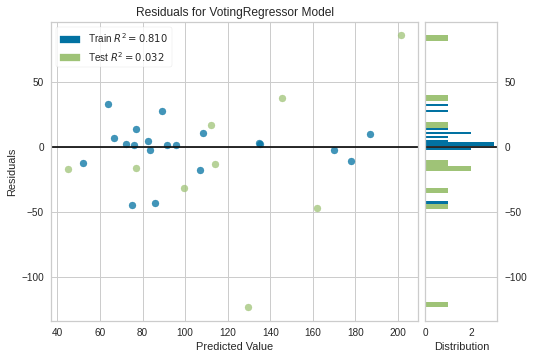

In [ ]:
plot_model(final_model)

In [ ]:
pred_s = predict_model(final_model, data=test_has_store)
pred_s.head()

,총세대수,단지내주차면수,대중교통,공급유형_공공임대,지역_경상남도,지역_부산광역시,지역_충청남도,40대(여자),50대(여자),50대(남자),80대(남자),90대(여자),90대(남자),100대(남자),단지당자동차보유수,Label
C1006,1505.0,428.0,7.0,0.0,0.0,0.0,0.0,0.074667,0.085751,0.068819,0.013751,0.006494,0.001740,0.000066,1336.690600,148.053823
C2676,2572.0,418.0,2.0,0.0,0.0,1.0,0.0,0.061952,0.082899,0.068855,0.020228,0.008043,0.002240,0.000028,1912.089661,212.930973
C2177,1245.0,187.0,1.0,0.0,0.0,0.0,1.0,0.078860,0.079299,0.069167,0.010900,0.005429,0.001549,0.000123,1137.816230,123.852694
C2033,1400.0,308.0,7.0,0.0,0.0,0.0,0.0,0.078450,0.084845,0.067709,0.011912,0.004221,0.001087,0.000000,1439.199988,140.527219
C1812,1021.0,185.0,4.0,0.0,0.0,0.0,0.0,0.078450,0.084845,0.067709,0.011912,0.004221,0.001087,0.000000,1049.587991,97.336555


### 상가 없는 경우

In [ ]:
reg2 = setup(train_apt_only, target='등록차량수', session_id=123)

,Description,Value
0,session_id,123
1,Target,등록차량수
2,Original Data,"(351, 12)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(245, 11)"


In [ ]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,116.1862,23093.3681,151.7222,0.6507,0.3859,0.3671,0.140
rf,Random Forest Regressor,115.9500,24531.5953,156.1134,0.6336,0.3472,0.3073,0.524
llar,Lasso Least Angle Regression,118.8420,25163.6300,157.1674,0.6277,0.3761,0.3592,0.022
huber,Huber Regressor,117.7814,25093.4487,157.0367,0.6252,0.3481,0.3157,0.062
ridge,Ridge Regression,118.7393,25135.9916,157.3022,0.6251,0.3596,0.3332,0.020
lasso,Lasso Regression,118.8409,25180.7379,157.4324,0.6245,0.3608,0.3343,0.024
lr,Linear Regression,119.1419,25227.9834,157.7731,0.6235,0.3608,0.3313,0.020
et,Extra Trees Regressor,119.8251,25294.5308,158.8345,0.6209,0.3613,0.3326,0.486
en,Elastic Net,120.1341,25574.1785,158.6458,0.6186,0.3704,0.3440,0.028
lar,Least Angle Regression,121.0858,25753.9853,159.8269,0.6145,0.3658,0.3356,0.024


In [ ]:
rf = create_model('rf', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,123.3118,26567.1324,162.9943,0.6627,0.4546,0.4547
1,124.1924,26886.4214,163.9708,0.6012,0.2653,0.2257
2,123.1151,26083.2250,161.5030,0.5527,0.3165,0.2601
3,91.0008,17129.1388,130.8783,0.7025,0.3680,0.3213
4,118.1298,25992.0588,161.2205,0.6491,0.3316,0.2749
Mean,115.9500,24531.5953,156.1134,0.6336,0.3472,0.3073
SD,12.6545,3715.5212,12.6572,0.0518,0.0630,0.0798


In [ ]:
tuned_rf = tune_model(rf, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,130.5630,30752.1989,175.3630,0.6096,0.5381,0.5924
1,117.3370,23406.8900,152.9931,0.6528,0.2536,0.2126
2,117.7985,23003.7543,151.6699,0.6055,0.3091,0.2590
3,85.9824,15477.8672,124.4101,0.7312,0.3774,0.3274
4,113.2546,22905.1875,151.3446,0.6908,0.3283,0.2826
Mean,112.9871,23109.1796,151.1561,0.6580,0.3613,0.3348
SD,14.6990,4833.0949,16.1555,0.0481,0.0969,0.1340


In [ ]:
huber = create_model('huber', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,128.5158,26628.5251,163.1825,0.6619,0.4922,0.5236
1,125.9530,26515.6866,162.8364,0.6067,0.2711,0.2313
2,132.7860,31155.5301,176.5093,0.4657,0.3290,0.2807
3,79.4442,13601.1533,116.6240,0.7638,0.3358,0.2717
4,122.2079,27566.3484,166.0312,0.6279,0.3122,0.2710
Mean,117.7814,25093.4487,157.0367,0.6252,0.3481,0.3157
SD,19.4755,5988.5914,20.8071,0.0963,0.0755,0.1053


In [ ]:
tuned_huber = tune_model(huber, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,128.6239,26716.8770,163.4530,0.6608,0.4995,0.5388
1,125.7345,26866.8809,163.9112,0.6015,0.2683,0.2283
2,127.0790,29110.5586,170.6182,0.5007,0.3201,0.2686
3,79.5792,13667.6253,116.9086,0.7626,0.3337,0.2716
4,120.6477,28346.4069,168.3639,0.6173,0.3117,0.2660
Mean,116.3329,24941.6697,156.6510,0.6286,0.3467,0.3146
SD,18.5709,5708.4805,20.0535,0.0851,0.0795,0.1132


In [ ]:
lgbm = create_model('lightgbm', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,113.8237,21508.4937,146.6577,0.7269,0.5631,0.6669
1,117.2771,22609.0538,150.3631,0.6647,0.2603,0.2212
2,132.8765,27233.6908,165.0263,0.5329,0.3537,0.2923
3,96.8991,19571.7493,139.8991,0.6601,0.4007,0.3504
4,120.0544,24543.8531,156.6648,0.6687,0.3517,0.3044
Mean,116.1862,23093.3681,151.7222,0.6507,0.3859,0.3671
SD,11.5956,2622.7606,8.5873,0.0637,0.0996,0.1555


In [ ]:
tuned_lgbm = tune_model(lgbm, optimize='MAE', fold=5, n_iter=50)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,124.6639,27871.4295,166.9474,0.6461,0.5703,0.6898
1,121.6583,24781.5697,157.4216,0.6325,0.2736,0.2272
2,121.6989,25112.9966,158.4708,0.5693,0.3295,0.2765
3,86.0792,14236.4904,119.3168,0.7527,0.3297,0.2750
4,125.7613,27909.3454,167.0609,0.6232,0.3636,0.3197
Mean,115.9723,23982.3663,153.8435,0.6448,0.3733,0.3576
SD,15.0339,5048.6657,17.7354,0.0599,0.1026,0.1686


In [ ]:
blender = blend_models(estimator_list = [tuned_huber, tuned_lgbm, tuned_rf], fold=5, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,123.3179,26502.8140,162.7968,0.6635,0.5328,0.5986
1,116.1993,22719.7118,150.7306,0.6630,0.2575,0.2159
2,112.8080,22541.4013,150.1379,0.6134,0.3067,0.2492
3,77.9782,12988.8823,113.9688,0.7744,0.3394,0.2804
4,115.9294,24846.7796,157.6286,0.6646,0.3293,0.2820
Mean,109.2466,21919.9178,147.0526,0.6758,0.3531,0.3252
SD,16.0087,4698.0584,17.1891,0.0530,0.0942,0.1388


In [ ]:
best = automl(optimize='MAE')
best

VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=0.01, epsilon=1,
                                            fit_intercept=True, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('lightgbm',
                             LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                                           boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           feature_fraction=0.9,
                                           importance_type='split',
                                           learning_rate=0.3, max_depth=-1,
                                           min_child_samples=...
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                     

In [ ]:
final_model = finalize_model(best)

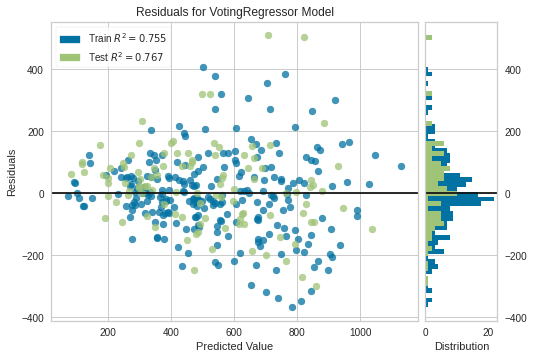

In [ ]:
plot_model(final_model)

In [ ]:
pred_a = predict_model(final_model, data=test_apt_only)
pred_a.head()

,총세대수,공가수,단지내주차면수,공급유형_행복주택,10대(여자),10대(남자),20대(여자),20대(남자),30대(남자),50대(남자),단지당자동차보유수,Label
C1072,754.0,14.0,683.0,0.0,0.052546,0.053990,0.058484,0.059894,0.068704,0.064859,671.582836,685.131780
C1128,1354.0,9.0,1216.0,0.0,0.052546,0.053990,0.058484,0.059894,0.068704,0.064859,1205.998886,952.025354
C1456,619.0,18.0,547.0,0.0,0.032681,0.035512,0.053796,0.057233,0.048866,0.068855,460.180210,504.294070
C1840,593.0,7.0,543.0,0.0,0.059685,0.060080,0.066262,0.070322,0.046596,0.074382,518.620197,513.873671
C1332,1297.0,11.0,1112.0,0.0,0.052546,0.053990,0.058484,0.059894,0.068704,0.064859,1155.229361,924.650737


In [ ]:
pred_a = pred_a[['Label']].copy()
pred_s = pred_s[['Label']].copy()

## 코드 제출

In [ ]:
submission = pd.read_csv(path+ "/sample_submission.csv")

In [ ]:
submission['num'] = submission['num'].astype('float')

In [ ]:
for i in range(len(submission)):
  for _ in range(len(pred_s)):
    if submission['code'][i] == pred_s.index[_]:
      submission['num'][i] = pred_s['Label'][_]
  for _ in range(len(pred_a)):
    if submission['code'][i] == pred_a.index[_]:
      submission['num'][i] = pred_a['Label'][_]


In [ ]:
submission

,code,num
0,C1072,685.131780
1,C1128,952.025354
2,C1456,504.294070
3,C1840,513.873671
4,C1332,924.650737
...,...,...
145,C2456,310.173969
146,C1266,513.888262
147,C2152,140.865936
148,C1267,421.753543


In [ ]:
submission.to_csv('submit.csv', index=False,float_format='%.4f')